# Quantum Verification Hand-on

## Setup and Installation

To install MQT QCEC run:
```console
pip install mqt.qcec
```
in your preferred virtual environment.

## Checking the equivalence of two circuits

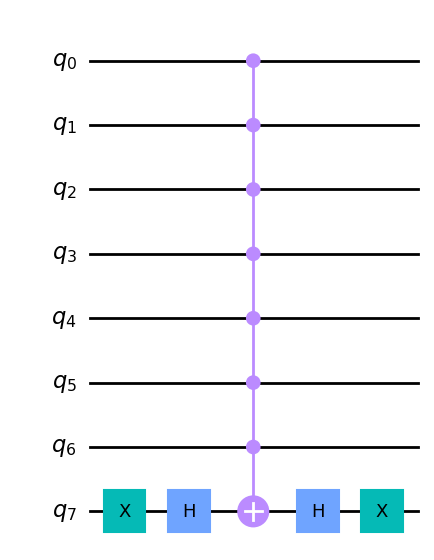

In [22]:
from qiskit import QuantumCircuit
import numpy as np

# qc1 = QuantumCircuit(2)
# qc1.swap(0, 1)

# qc1 = QuantumCircuit(2)
# qc1.cx(0, 1)

num_qubits = 8
qc1 = QuantumCircuit(num_qubits)
qc1.x(num_qubits - 1)
qc1.h(num_qubits - 1)
qc1.mcx(list(range(num_qubits - 1)), num_qubits - 1)
qc1.h(num_qubits - 1)
qc1.x(num_qubits - 1)

qc1.draw(output="mpl")

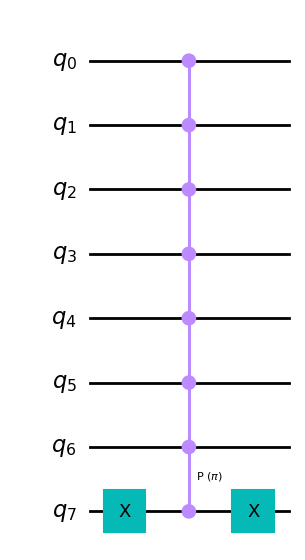

In [23]:
# qc2 = QuantumCircuit(2)
# qc2.cx(0, 1)
# qc2.cx(1, 0)
# qc2.cx(0, 1)

# qc2 = QuantumCircuit(2)
# qc2.h(0)
# qc2.h(1)
# qc2.cx(1, 0)
# qc2.h(0)
# qc2.h(1)

qc2 = QuantumCircuit(num_qubits)
qc2.x(num_qubits - 1)
qc2.mcp(np.pi, list(range(num_qubits - 1)), num_qubits - 1)
qc2.x(num_qubits - 1)

qc2.draw(output="mpl")

## Using Qiskit to verify the equivalence

In [24]:
from qiskit.quantum_info import Operator

op1 = Operator(qc1)
print(op1)
op2 = Operator(qc2)
print(f"Are the two operators equivalent? {op1 == op2}")

Operator([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 1.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 1.+0.j]],
         input_dims=(2, 2, 2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2, 2, 2))
Are the two operators equivalent? True


In [25]:
%timeit op1 = Operator(qc1); op2 = Operator(qc2); op1 == op2

376 ms ± 5.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Using TKET to verify the equivalence

In [32]:
from pytket.extensions.qiskit import qiskit_to_tk
from pytket.circuit.display import render_circuit_jupyter
from pytket.passes import auto_rebase_pass
from pytket.circuit import OpType

circ1 = qiskit_to_tk(qc1.decompose(reps=2))

custom = auto_rebase_pass(gateset={OpType.Rz, OpType.Rx, OpType.X, OpType.Z, OpType.H, OpType.CX, OpType.CZ})
custom.apply(circ1)

render_circuit_jupyter(circ1)

In [35]:
circ2 = qiskit_to_tk(qc2.decompose())
custom.apply(circ2)
render_circuit_jupyter(circ2)

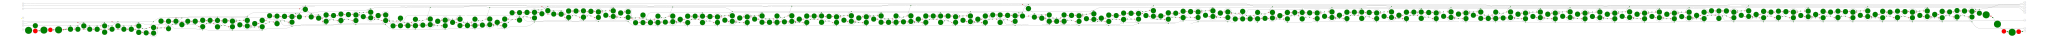

In [36]:
from pytket.zx import circuit_to_zx
import graphviz as gv

zx1, _ = circuit_to_zx(circ1)
gv.Source(zx1.to_graphviz_str())

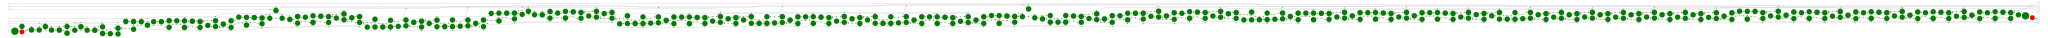

In [37]:
zx2, _ = circuit_to_zx(circ2)
gv.Source(zx2.to_graphviz_str())

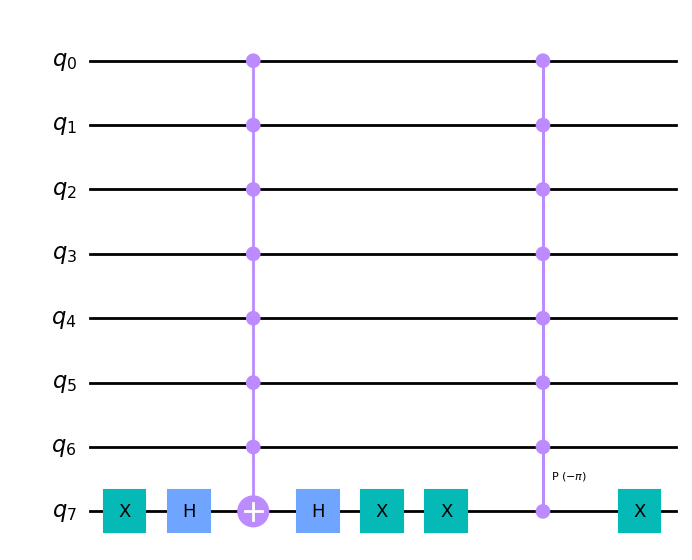

In [38]:
qc_combined = qc1.compose(qc2.inverse())
qc_combined.draw(output="mpl")

In [40]:
from pytket.passes import FullPeepholeOptimise

circ_combined = qiskit_to_tk(qc_combined.decompose(reps=2))
custom.apply(circ_combined)
FullPeepholeOptimise().apply(circ_combined)
render_circuit_jupyter(circ_combined)

In [41]:
%%timeit circ_combined = qiskit_to_tk(qc_combined.decompose(reps=2))
FullPeepholeOptimise().apply(circ_combined)

8.15 s ± 34.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Verification using MQT QCEC

In [42]:
from mqt import qcec

qcec.verify(qc1, qc2)

{
  "check_time": 0.021428271,
  "equivalence": "equivalent",
  "parameterized": {
    "performed_instantiations": 0
  },
  "preprocessing_time": 0.000700004,
  "simulations": {
    "performed": 12,
    "started": 16
  }
}

In [43]:
%timeit qcec.verify(qc1, qc2)

19.3 ms ± 821 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Verification of Compilation Flow Results

In [44]:
from qiskit import transpile
from qiskit.providers.fake_provider import FakeCasablancaV2
from qiskit.quantum_info import random_clifford

### Considered Circuits

Let's just consider a random Clifford circuit with 7 qubits.

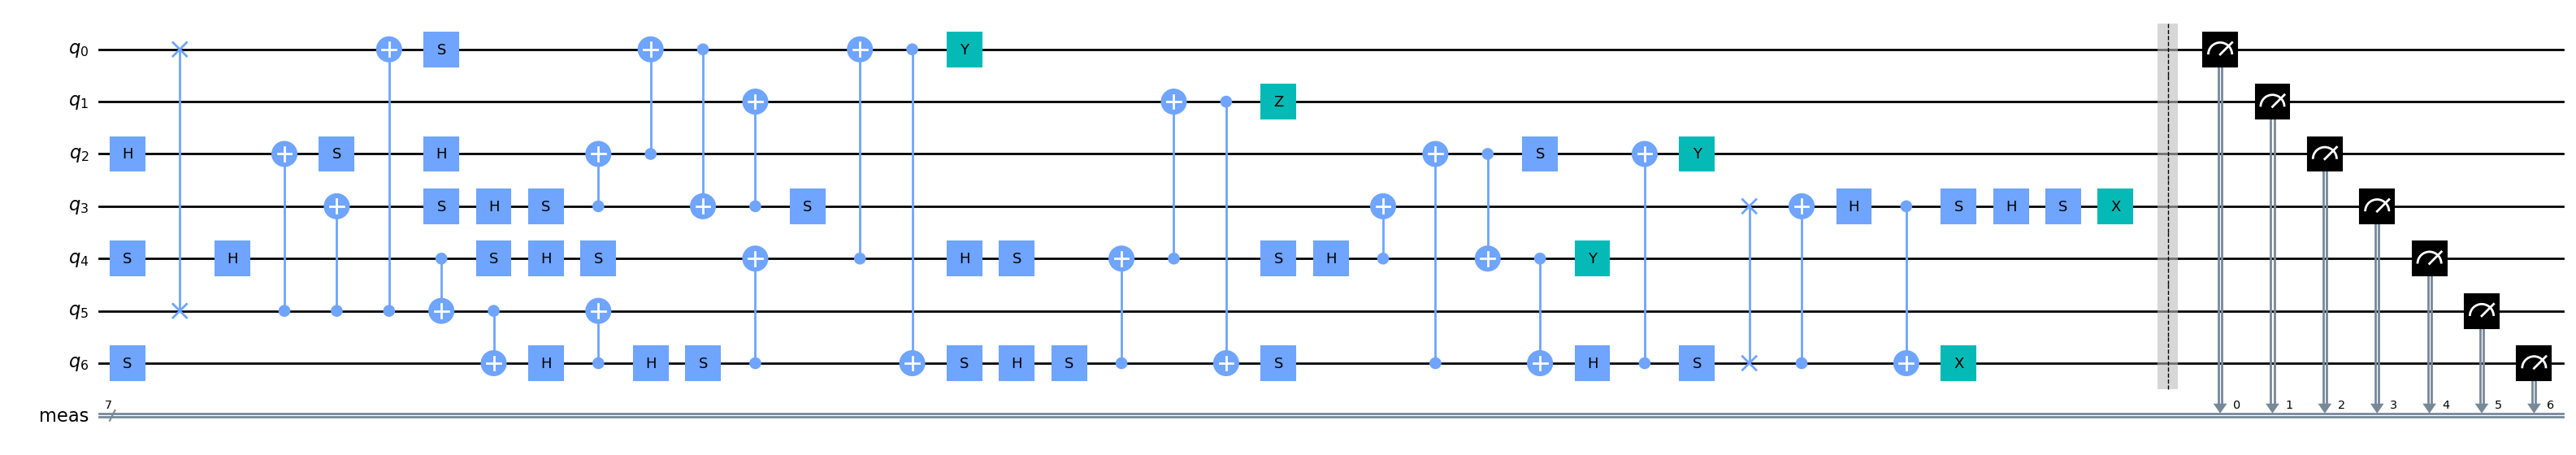

In [45]:
num_qubits = 7
depth = num_qubits
seed = 42
qc = random_clifford(num_qubits, seed=seed).to_circuit()
qc.measure_all()
qc.draw(output="mpl", fold=-1)

Let's compile that circuit to a 7-qubit IBM device

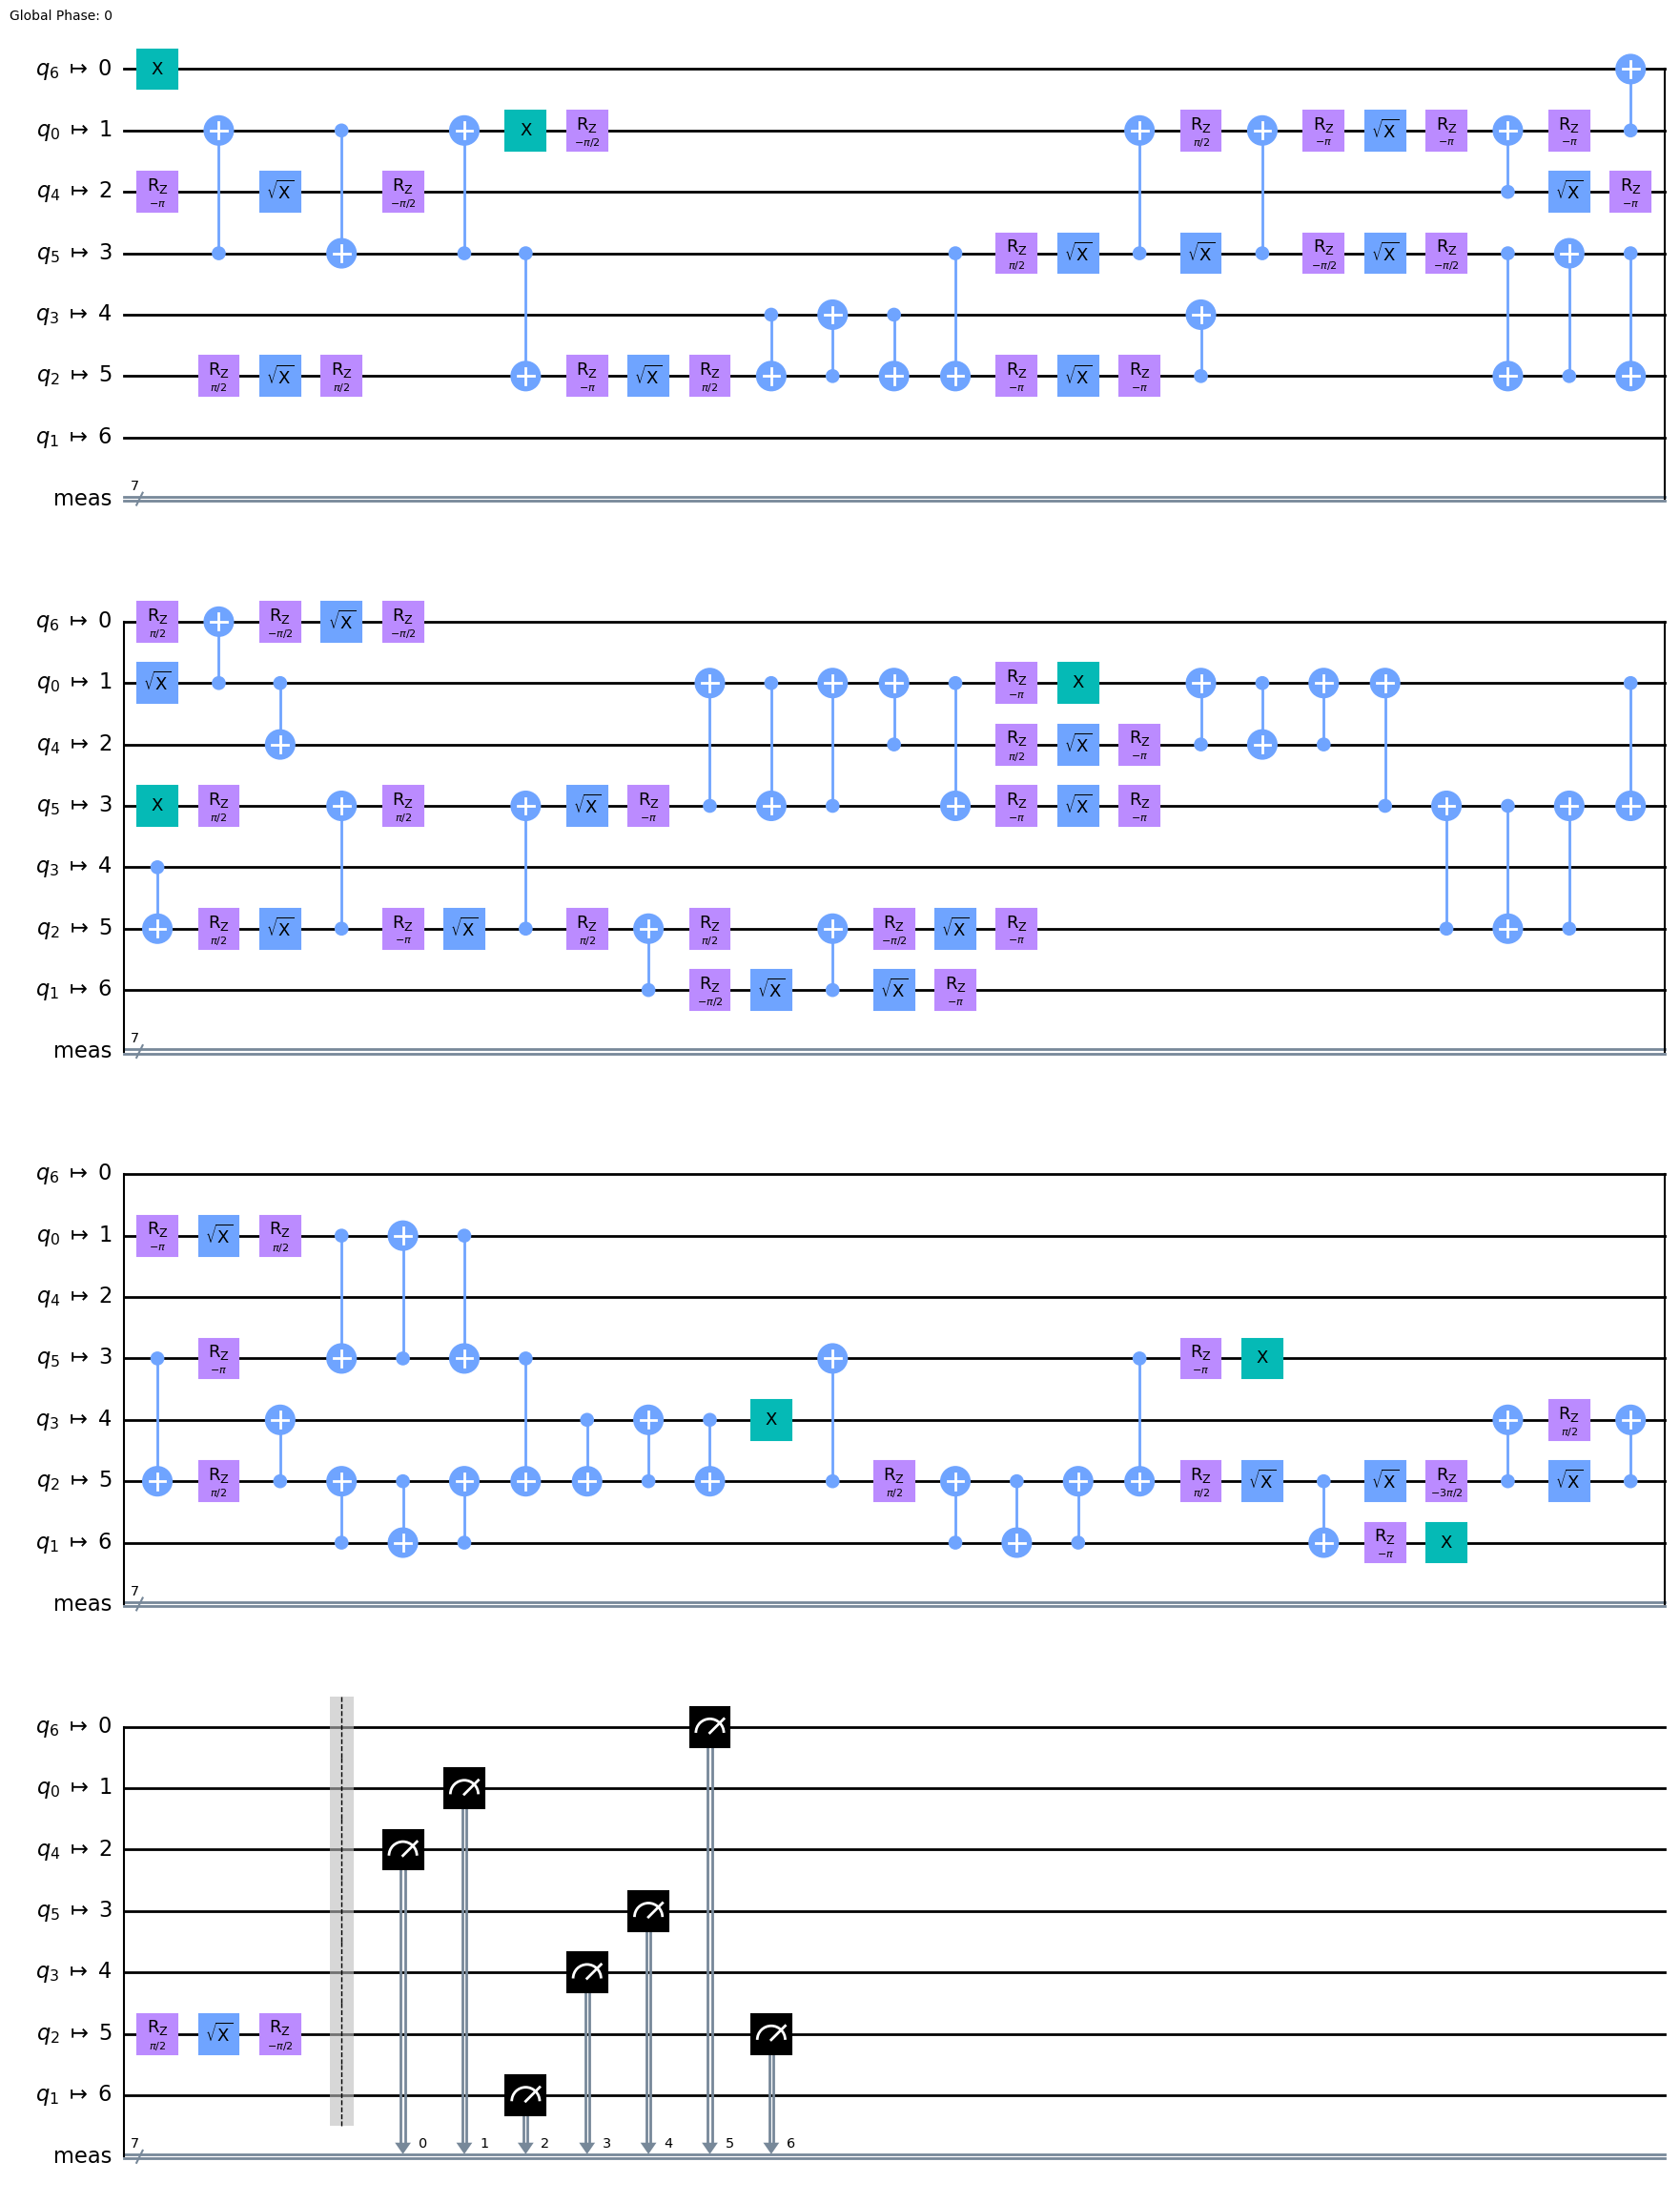

In [16]:
optimization_level=3
qc_comp = transpile(qc, backend=FakeCasablancaV2(), optimization_level=optimization_level)
qc_comp.draw(output="mpl")

### Checking the equivalence of these circuits using MQT QCEC

In [17]:
from mqt import qcec

qcec.verify_compilation(qc, qc_comp, optimization_level=optimization_level)

{
  "check_time": 0.007499626,
  "equivalence": "equivalent_up_to_global_phase",
  "parameterized": {
    "performed_instantiations": 0
  },
  "preprocessing_time": 0.000718462,
  "simulations": {
    "performed": 0,
    "started": 14
  }
}

In [18]:
%timeit qcec.verify_compilation(qc, qc_comp, optimization_level=optimization_level)

23.2 ms ± 980 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Playground

In [19]:
from mqt.qcec import Configuration, EquivalenceCheckingManager

num_qubits = 32
qc1 = QuantumCircuit(num_qubits)
qc1.x(num_qubits - 1)
qc1.h(num_qubits - 1)
qc1.mcx(list(range(num_qubits - 1)), num_qubits - 1)
qc1.h(num_qubits - 1)
qc1.x(num_qubits - 1)

qc2 = QuantumCircuit(num_qubits)
qc2.x(num_qubits - 1)
qc2.mcp(np.pi, list(range(num_qubits - 1)), num_qubits - 1)
qc2.x(num_qubits - 1)

config = Configuration()

ecm = EquivalenceCheckingManager(circ1=qc1, circ2=qc2, config=config)

ecm.run()

ecm

{
  "checkers": [
    {
      "checker": "decision_diagram_alternating",
      "equivalence": "equivalent",
      "max_nodes": 64,
      "runtime": 0.000411808
    },
    {
      "checker": "decision_diagram_simulation",
      "equivalence": "no_information",
      "max_nodes": 0,
      "runtime": 0.0
    },
    {
      "checker": "decision_diagram_simulation",
      "equivalence": "no_information",
      "max_nodes": 0,
      "runtime": 0.0
    },
    {
      "checker": "decision_diagram_simulation",
      "equivalence": "equivalent",
      "max_nodes": 34,
      "runtime": 0.00432712
    },
    {
      "checker": "decision_diagram_simulation",
      "equivalence": "no_information",
      "max_nodes": 0,
      "runtime": 0.0
    },
    {
      "checker": "decision_diagram_simulation",
      "equivalence": "equivalent",
      "max_nodes": 34,
      "runtime": 0.001861786
    },
    {
      "checker": "decision_diagram_simulation",
      "equivalence": "no_information",
      "max_nodes